# Machine Learning Project with SMOTE, PCA, and Nested Cross-Validation

In this notebook, we will:
1. Handle imbalanced data using SMOTE.
2. Perform feature selection using PCA.
3. Use Nested Cross-Validation (5 inner, 5 outer) for training and evaluation.
4. Train models using Random Forest and Logistics Networks.
5. Evaluate the models using metrics such as sensitivity, specificity, AUC, and likelihood ratios.


# Step 0: Connect Google Drive and Set Directories
We will connect Google Drive to save the trained models and load the dataset.


In [ ]:
from google.colab import drive
import os

# Connect to Google Drive
drive.mount('/content/drive')

# Path to the data file (you can update it later if needed)
data_path = '/content/drive/MyDrive/Health A3/final_data_log.csv'

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Step 1: Handle Imbalanced Data with SMOTE and Convert Gender to Numeric
We will apply SMOTE to handle imbalanced data and convert the 'gender' column ('male' to 0 and 'female' to 1).


In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv(data_path)

# Split into features (X) and target (y)
X = data.drop(columns='mortality_status')
# X= data.drop(columns=['mortality_status','Urineoutput_7day_after','Urineoutput_7day_before'])
y = data['mortality_status']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Step 2: Feature Selection using PCA
We will reduce the dimensionality of the dataset using PCA, keeping only the most relevant features.


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

##mark down feature name and replace later in Shapley Analysis
feature_names = X_train_resampled.columns
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Useful to reconstruct features in SHAP analysis
loading_matrix = pca.components_


# Step 3: Nested Cross-Validation Setup
We will use a 5x5 nested cross-validation (5 inner and 5 outer folds) to split the data for training and evaluation.


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Set up nested cross-validation
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


# Step 4: Nested Cross-Validation with Hyperparameter Tuning
We will perform nested cross-validation to optimize the hyperparameters for both Decision Tree and MLP models.



In [ ]:
import joblib
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Directory to save models
model_dir = '/content/drive/MyDrive/trained_models'  # Adjust this path as needed
os.makedirs(model_dir, exist_ok=True)

# PyTorch device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PyTorch MLP Model Definition
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Function to train PyTorch MLP
def train_mlp(model, X_train, y_train, criterion, optimizer, epochs=50):
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
        labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    return model

# Hyperparameter space for PyTorch MLP
hidden_sizes_options = [[50, 50], [100, 50]]
learning_rates = [0.001, 0.01]
epochs = 50

# Nested cross-validation setup
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform nested cross-validation for PyTorch MLP
best_auc_scores = []

for train_idx, test_idx in outer_cv.split(X_train_pca, y_train_resampled):
    X_outer_train, X_outer_test = X_train_pca[train_idx], X_train_pca[test_idx]
    y_outer_train, y_outer_test = y_train_resampled[train_idx], y_train_resampled[test_idx]

    # Define input and output sizes for the MLP model
    input_size = X_outer_train.shape[1]  # Number of features (columns)
    output_size = 1  # Assuming binary classification

    best_auc = 0
    best_model = None

    # Inner CV loop for hyperparameter tuning
    y_outer_train_np = np.array(y_outer_train)

    for inner_train_idx, inner_val_idx in inner_cv.split(X_outer_train, y_outer_train_np):
        X_inner_train, X_val = X_outer_train[inner_train_idx], X_outer_train[inner_val_idx]
        y_inner_train, y_val = y_outer_train_np[inner_train_idx], y_outer_train_np[inner_val_idx]

        for hidden_sizes in hidden_sizes_options:
            for lr in learning_rates:
                mlp_model = MLP(input_size, hidden_sizes, output_size)
                optimizer = optim.Adam(mlp_model.parameters(), lr=lr)
                criterion = nn.BCELoss()

                mlp_model = train_mlp(mlp_model, X_inner_train, y_inner_train, criterion, optimizer, epochs=epochs)
                y_val_pred = mlp_model(torch.tensor(X_val, dtype=torch.float32).to(device)).detach().cpu().numpy()
                auc_val = roc_auc_score(y_val, y_val_pred)

                if auc_val > best_auc:
                    best_auc = auc_val
                    best_model = mlp_model

    # Evaluate the best model on outer test set
    y_test_pred = best_model(torch.tensor(X_outer_test, dtype=torch.float32).to(device)).detach().cpu().numpy()
    auc_test = roc_auc_score(y_outer_test, y_test_pred)
    best_auc_scores.append(auc_test)

# Save the best model found during cross-validation
torch.save(best_model.state_dict(), os.path.join(model_dir, 'best_mlp_model_torch.pth'))
print(f"Saved the best PyTorch MLP model to 'best_mlp_model_torch.pth'")

# Hyperparameter testing for scikit-learn models
param_grid_dt = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
param_grid_knn = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}
param_grid_gbm = {'n_estimators': [50, 100], 'max_depth': [3, 5, 10]}
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [10, 20]}  # Random Forest
param_grid_lr = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}  # Logistic Regression

# Models dictionary including Random Forest and Logistic Regression
models = {
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid_dt, cv=inner_cv, scoring='roc_auc'),
    'Naive Bayes': GaussianNB(),
    'KNN': GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=inner_cv, scoring='roc_auc'),
    'GBM': GridSearchCV(GradientBoostingClassifier(random_state=1), param_grid_gbm, cv=inner_cv, scoring='roc_auc'),
    'Random Forest': GridSearchCV(RandomForestClassifier(random_state=1), param_grid_rf, cv=inner_cv, scoring='roc_auc'),
    'Logistic Regression': GridSearchCV(LogisticRegression(random_state=1), param_grid_lr, cv=inner_cv, scoring='roc_auc')
}

# Hyperparameter testing for scikit-learn models and saving best models
for name, model in models.items():
    model.fit(X_train_pca, y_train_resampled)
    best_model = model.best_estimator_ if isinstance(model, GridSearchCV) else model
    joblib.dump(best_model, os.path.join(model_dir, f'{name}_model.pkl'))
    print(f"Saved {name} model to '{name}_model.pkl'")


Saved the best PyTorch MLP model to 'best_mlp_model_torch.pth'
Saved Decision Tree model to 'Decision Tree_model.pkl'
Saved Naive Bayes model to 'Naive Bayes_model.pkl'
Saved KNN model to 'KNN_model.pkl'
Saved GBM model to 'GBM_model.pkl'
Saved Random Forest model to 'Random Forest_model.pkl'
Saved Logistic Regression model to 'Logistic Regression_model.pkl'


# Step 5: Model Evaluation Metrics
We will evaluate the performance of both models using various metrics such as Sensitivity (Recall), Specificity, AUC, and Likelihood Ratios.


In [ ]:
import joblib
import pandas as pd
import torch
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix

# Evaluate scikit-learn models and save predictions
for name in ['Decision Tree', 'Naive Bayes', 'KNN', 'GBM', 'Random Forest', 'Logistic Regression']:
    model = joblib.load(os.path.join(model_dir, f'{name}_model.pkl'))

    # Make predictions and get probabilities
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]  # Extract probabilities for ROC

    # Create DataFrame for predictions and true values
    results_df_model = pd.DataFrame({'True Values': y_test_np, f'{name} Predictions': y_pred})

    # Save the predictions to CSV with unique name
    model_csv_path = os.path.join(model_dir, f'{name.lower().replace(" ", "_")}_predictions.csv')
    results_df_model.to_csv(model_csv_path, index=False)
    print(f"Saved {name} predictions to '{model_csv_path}'")

    # Calculate and print evaluation metrics for each model
    auc_score = roc_auc_score(y_test_np, y_pred_proba)
    sensitivity = recall_score(y_test_np, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_np, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results for each model
    print(f'{name} AUC: {auc_score:.3f}, Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}')

# Evaluate the PyTorch MLP Model
# Function to evaluate PyTorch MLP model
def evaluate_mlp(model, X_test):
    model.eval()
    inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
    outputs = model(inputs).detach().cpu().numpy()
    return outputs

# Load the best PyTorch MLP model
mlp_model_torch = MLP(input_size, hidden_sizes, output_size)
mlp_model_torch.load_state_dict(torch.load(os.path.join(model_dir, 'best_mlp_model_torch.pth')))
mlp_model_torch = mlp_model_torch.to(device)

# Evaluate MLP model
y_pred_mlp_torch_proba = evaluate_mlp(mlp_model_torch, X_test_pca).flatten()  # Flatten to 1D
y_pred_mlp_torch = (y_pred_mlp_torch_proba > 0.5).astype(int)  # Binarize predictions

# Create DataFrame for MLP predictions
results_df_mlp = pd.DataFrame({'True Values': y_test_np, 'MLP (PyTorch) Predictions': y_pred_mlp_torch})

# Save MLP predictions to CSV
mlp_csv_path = os.path.join(model_dir, 'mlp_pytorch_predictions.csv')
results_df_mlp.to_csv(mlp_csv_path, index=False)
print(f"Saved MLP (PyTorch) predictions to '{mlp_csv_path}'")

# Calculate evaluation metrics for MLP
auc_score_mlp = roc_auc_score(y_test_np, y_pred_mlp_torch_proba)
sensitivity_mlp = recall_score(y_test_np, y_pred_mlp_torch)
tn_mlp, fp_mlp, fn_mlp, tp_mlp = confusion_matrix(y_test_np, y_pred_mlp_torch).ravel()
specificity_mlp = tn_mlp / (tn_mlp + fp_mlp)

# Print MLP evaluation metrics
print(f'MLP (PyTorch) AUC: {auc_score_mlp:.3f}, Sensitivity: {sensitivity_mlp:.3f}, Specificity: {specificity_mlp:.3f}')


Saved Decision Tree predictions to '/content/drive/MyDrive/trained_models/decision_tree_predictions.csv'
Decision Tree AUC: 0.664, Sensitivity: 0.512, Specificity: 0.825
Saved Naive Bayes predictions to '/content/drive/MyDrive/trained_models/naive_bayes_predictions.csv'
Naive Bayes AUC: 0.838, Sensitivity: 0.610, Specificity: 0.883
Saved KNN predictions to '/content/drive/MyDrive/trained_models/knn_predictions.csv'
KNN AUC: 0.886, Sensitivity: 0.683, Specificity: 0.883
Saved GBM predictions to '/content/drive/MyDrive/trained_models/gbm_predictions.csv'
GBM AUC: 0.861, Sensitivity: 0.659, Specificity: 0.913
Saved Random Forest predictions to '/content/drive/MyDrive/trained_models/random_forest_predictions.csv'
Random Forest AUC: 0.869, Sensitivity: 0.683, Specificity: 0.874
Saved Logistic Regression predictions to '/content/drive/MyDrive/trained_models/logistic_regression_predictions.csv'
Logistic Regression AUC: 0.864, Sensitivity: 0.610, Specificity: 0.874
Saved MLP (PyTorch) predicti

# Step 6: Visualize Model Performance
We will visualize the performance of the models using ROC curves and confusion matrices.


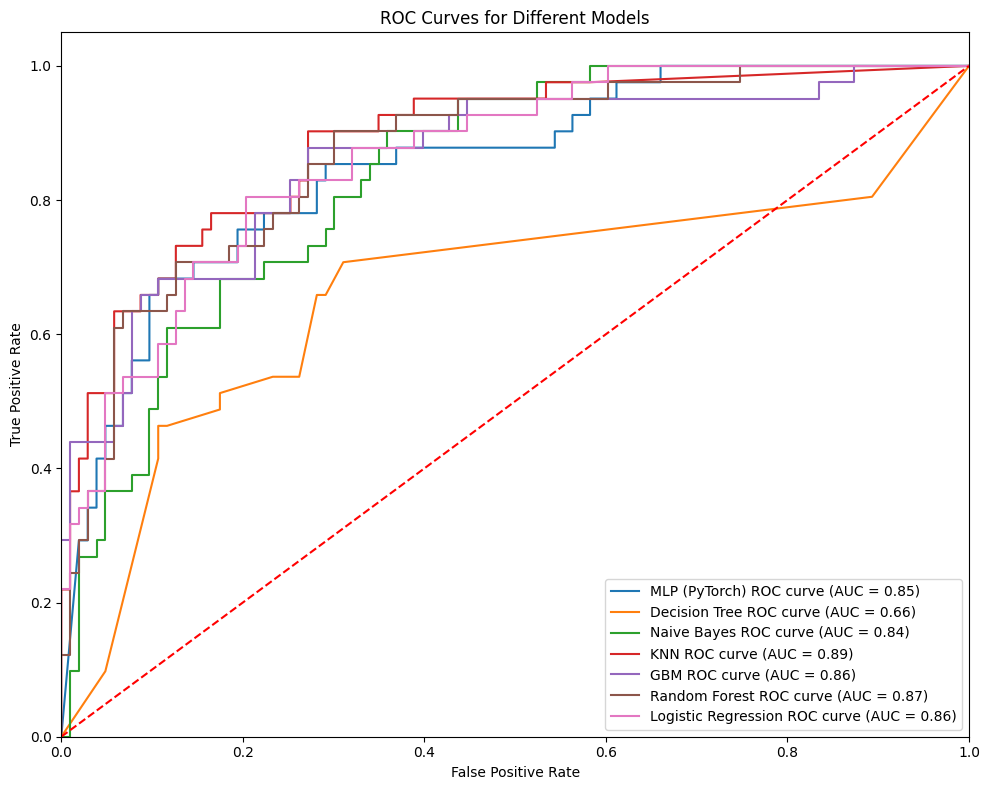

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import joblib
import os

# Plot combined ROC curves for all models, including PyTorch MLP
plt.figure(figsize=(10, 8))

# Plot ROC curve for PyTorch MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_np, y_pred_mlp_torch_proba)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (PyTorch) ROC curve (AUC = {roc_auc_mlp:.2f})')

# List of models to evaluate, now including Random Forest and Logistic Regression
model_names = ['Decision Tree', 'Naive Bayes', 'KNN', 'GBM', 'Random Forest', 'Logistic Regression']

# Plot ROC curves for scikit-learn models
for name in model_names:
    model = joblib.load(os.path.join(model_dir, f'{name}_model.pkl'))
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]  # Extract probabilities for ROC curve
    fpr, tpr, _ = roc_curve(y_test_np, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} ROC curve (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Reference diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.tight_layout()

# Show the plot
plt.show()


# Step 7: Confusion Matrix Visualization
We will visualize the confusion matrices for both Decision Tree and MLP models.


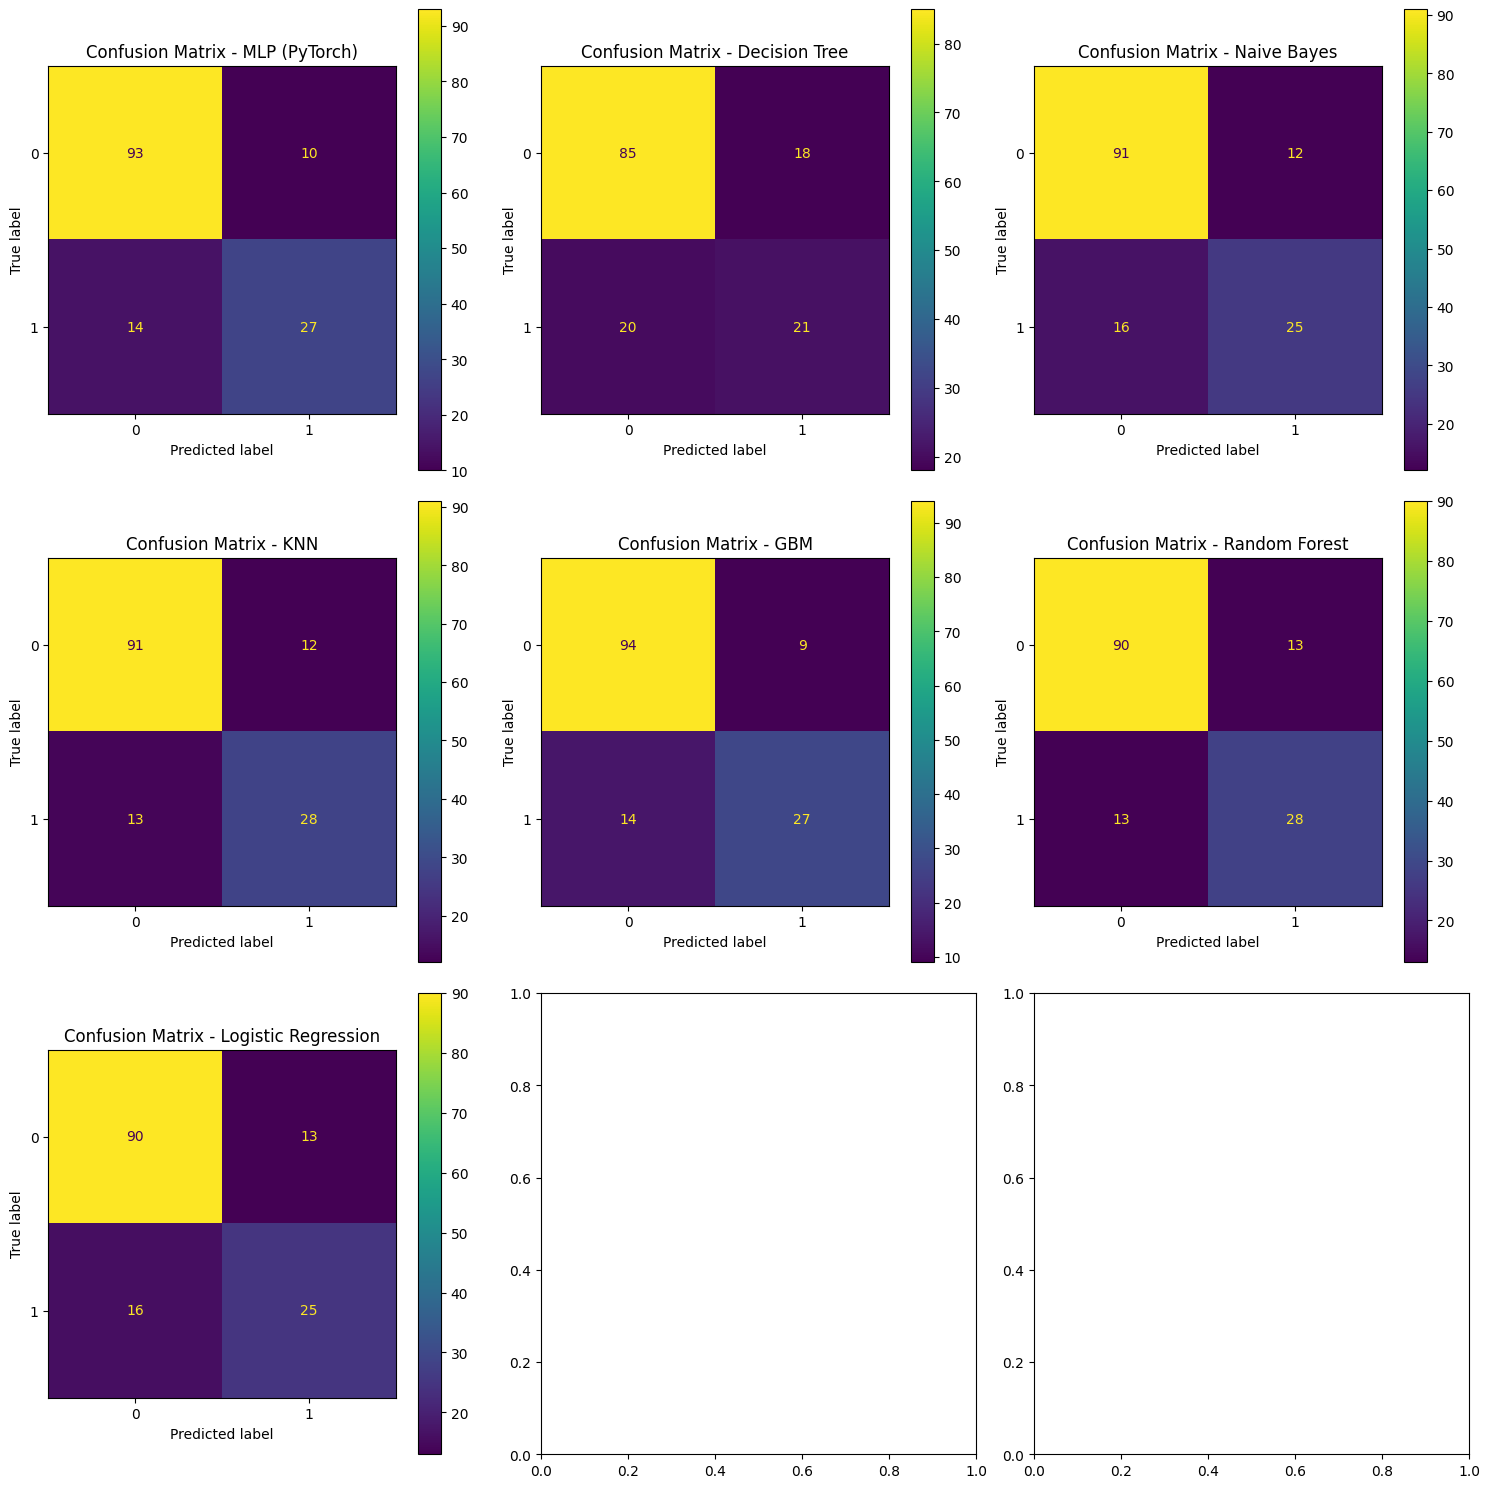

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
import os

# Create a figure with subplots (3 rows and 3 columns for 7 models)
fig, ax = plt.subplots(3, 3, figsize=(15, 15))  # 3 rows, 3 columns for 7 models

# Plot Confusion Matrix for PyTorch MLP at the first position (0, 0)
ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_mlp_torch, ax=ax[0, 0])
ax[0, 0].set_title('Confusion Matrix - MLP (PyTorch)')

# List of scikit-learn models to display
model_names = ['Decision Tree', 'Naive Bayes', 'KNN', 'GBM', 'Random Forest', 'Logistic Regression']

# Plot Confusion Matrices for scikit-learn models, starting at (0, 1)
for idx, name in enumerate(model_names, start=1):
    model = joblib.load(os.path.join(model_dir, f'{name}_model.pkl'))
    row = idx // 3  # Determine the row
    col = idx % 3   # Determine the column
    ConfusionMatrixDisplay.from_estimator(model, X_test_pca, y_test_np, ax=ax[row, col])
    ax[row, col].set_title(f'Confusion Matrix - {name}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


##Shapley analysis
We will interpret the best model by shapley analysis. First we draw out summary plots of GBM model. Top 15 feature importance is shown in summary plot. Then dependency shapley plots of top 5 features are drawn.

###GBM

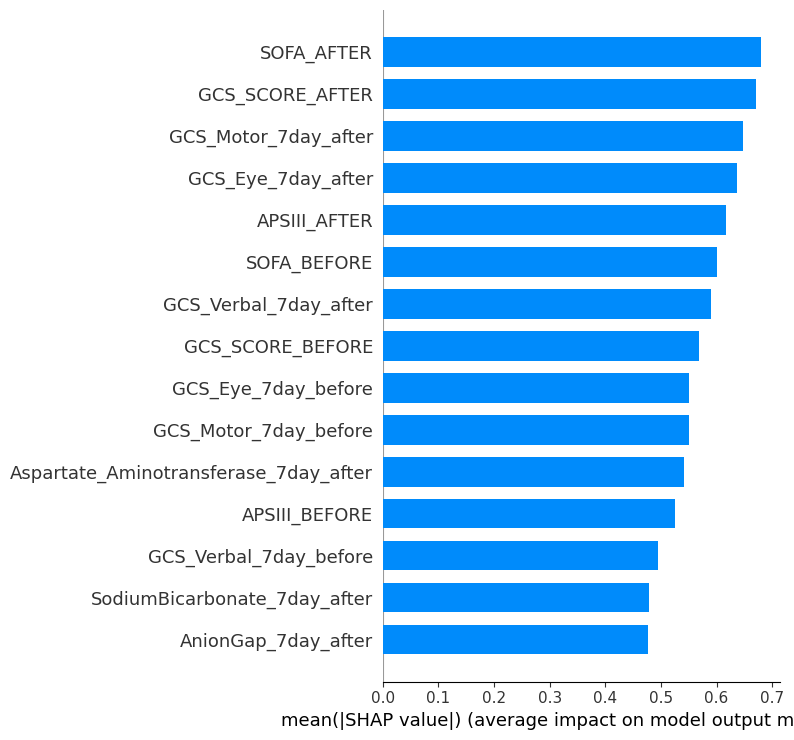

In [ ]:
import shap
import matplotlib.pyplot as plt
import joblib
import numpy as np

GBM_model = joblib.load('GBM_model.pkl')
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(GBM_model, X_test_pca)

# Calculate Shapley values
shap_values_pca = explainer(X_test_pca)

shap_values_scaled = np.dot(shap_values_pca.values, loading_matrix)

# shap_values_original = scaler.inverse_transform(shap_values_scaled)

# Summary plot - shows feature importance
shap.summary_plot(shap_values_scaled, X_test_scaled_df, max_display=15, plot_type="bar")

plt.show()


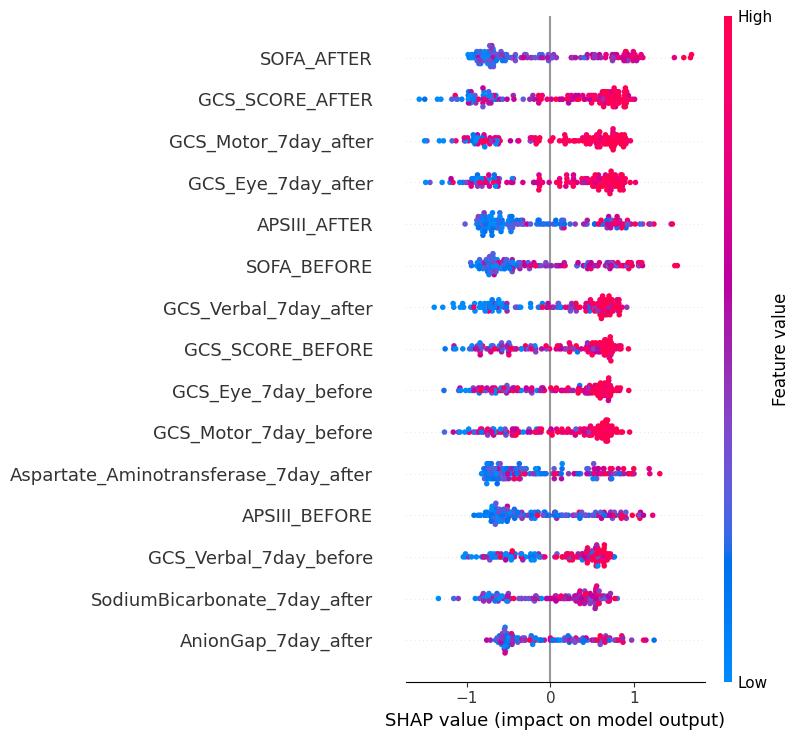

In [ ]:
shap.summary_plot(shap_values_scaled, X_test_scaled_df, max_display=15)

plt.show()

From the above summary plot of GBM model, several conclusions can be infered:
1. The most important features affecting the model predictions are SOFA_AFTER, GCS_SCORE_AFTER, GCS_Motor_7day_after, GCS_Eye_7day_after and APSIII_AFTER.
2. SOFA_AFTER has a significant impact on the model, with higher values (red) pushing the prediction higher (positive SHAP values) and lower values (blue) having a negative impact. This suggests that when the SOFA_AFTER score is high, the model is predicting higher risk of mortality.
3. GCS_SCORE_AFTER, GCS_Motor_7day_after, GCS_Eye_7day_after strongly indicates a linear relationship with mortality, with higher feature value(red) has higher risk of mortality.
4. If APSIII_AFTER is low(blue), then the patient is safer.
5. SodiumBicarbonate_7day_after and AnionGap_7day_after seems less importance, but still top15 features.

#### Dependency plots for top 5 features

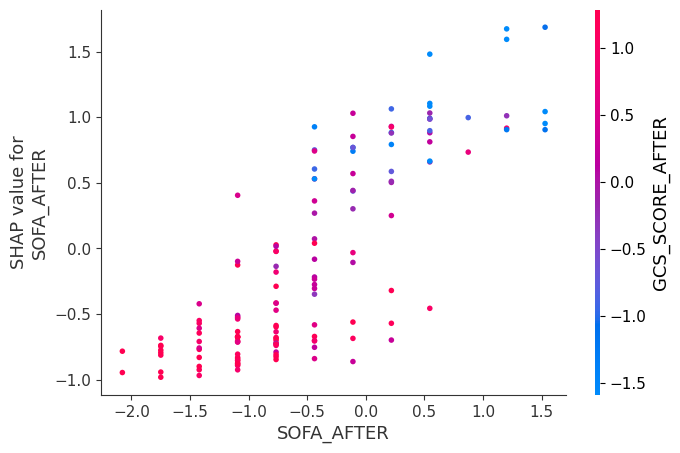

In [ ]:
# Dependence plot for a specific feature
shap.dependence_plot("SOFA_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()

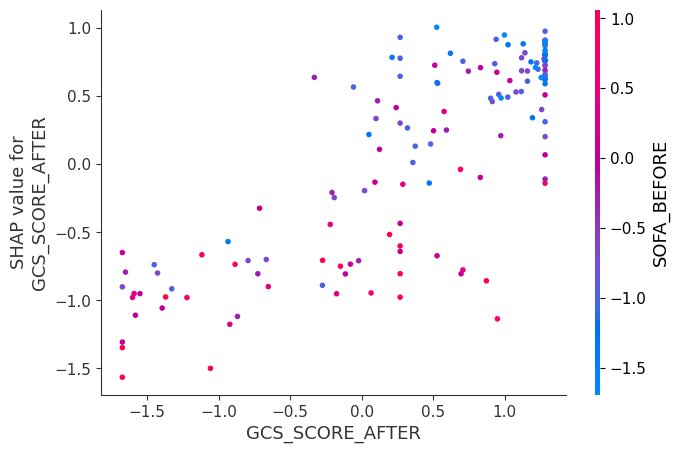

In [ ]:
shap.dependence_plot("GCS_SCORE_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()

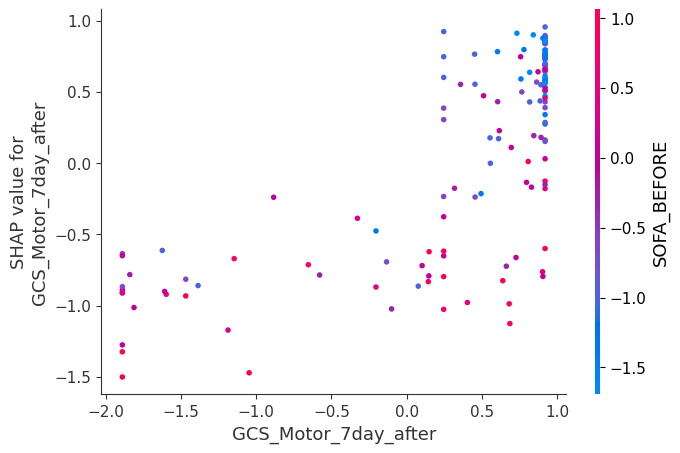

In [ ]:
shap.dependence_plot("GCS_Motor_7day_after", shap_values_scaled, X_test_scaled_df)
plt.show()

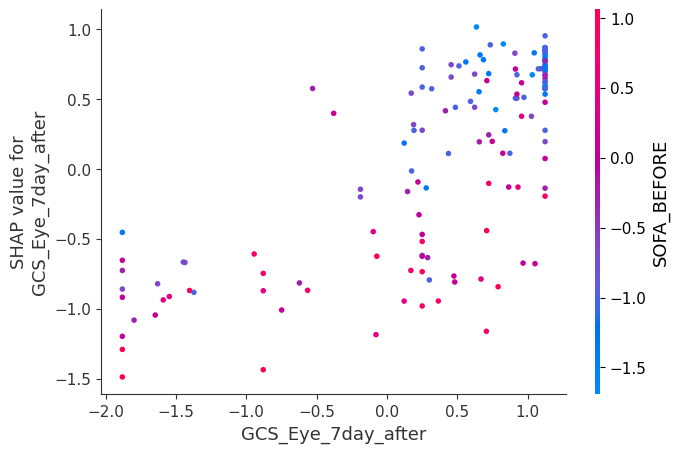

In [ ]:
shap.dependence_plot("GCS_Eye_7day_after", shap_values_scaled, X_test_scaled_df)
plt.show()

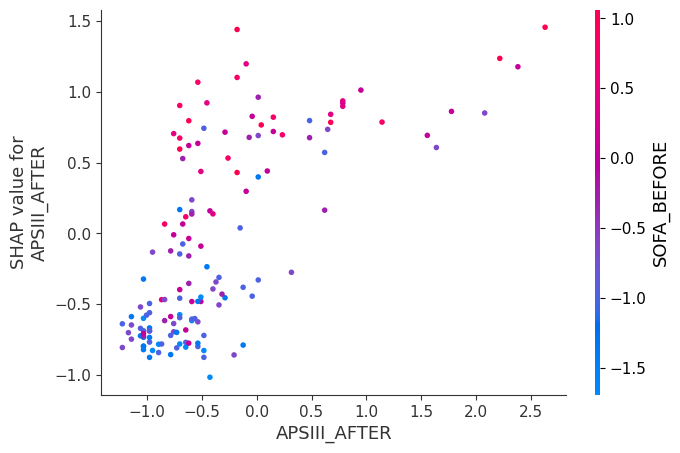

In [ ]:
shap.dependence_plot("APSIII_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()

###DT

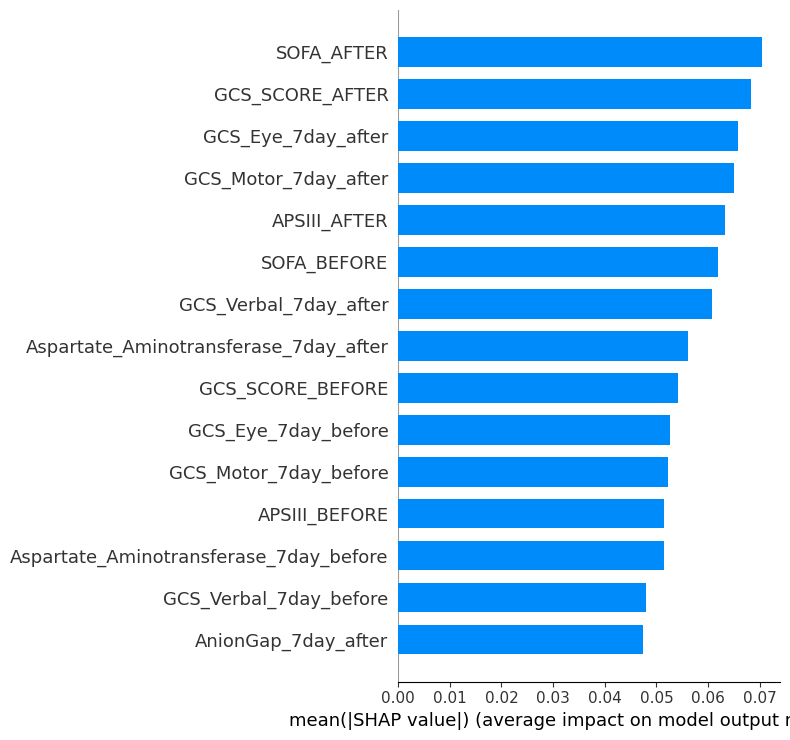

In [ ]:
import shap
import matplotlib.pyplot as plt
import joblib
import numpy as np

DT_model = joblib.load('Decision Tree_model.pkl')
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(DT_model, X_test_pca)

# Calculate Shapley values
shap_values_pca = explainer(X_test_pca)

shap_values_scaled = np.dot(shap_values_pca.values[:,:,1], loading_matrix)

# Summary plot - shows feature importance
shap.summary_plot(shap_values_scaled, X_test_scaled_df, max_display=15, plot_type='bar')

plt.show()

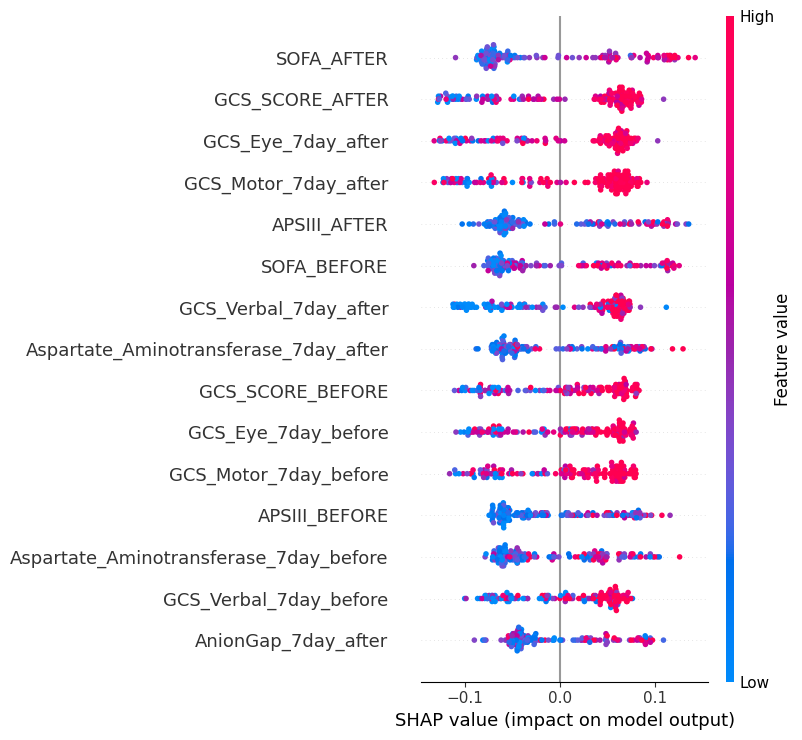

In [ ]:
shap.summary_plot(shap_values_scaled, X_test_scaled_df, max_display=15)
plt.show()

#### Dependency plots of 5 top features in DT

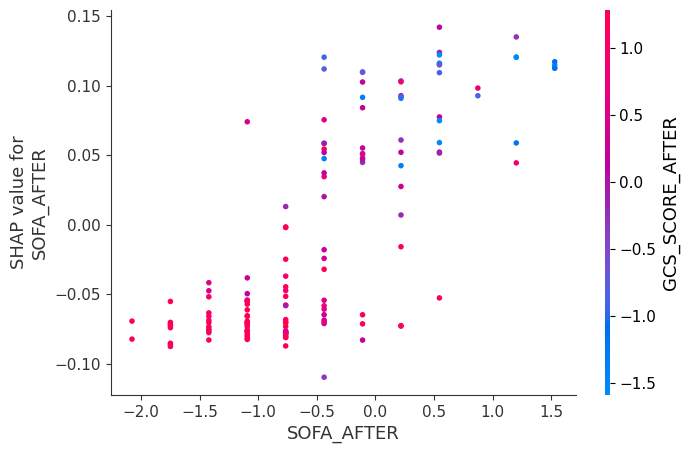

In [ ]:
shap.dependence_plot("SOFA_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()

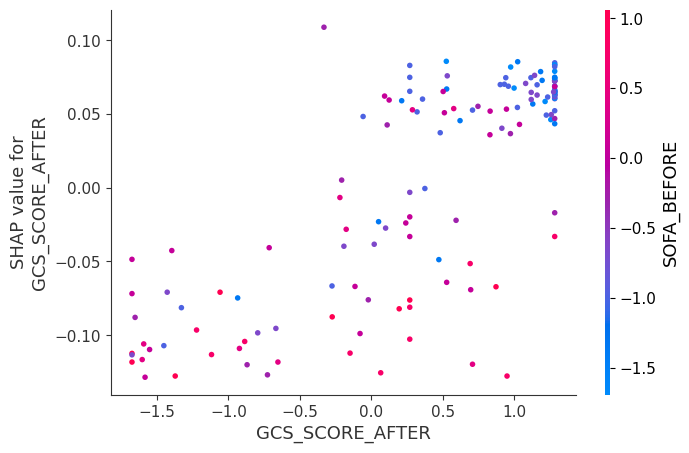

In [ ]:
shap.dependence_plot("GCS_SCORE_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()

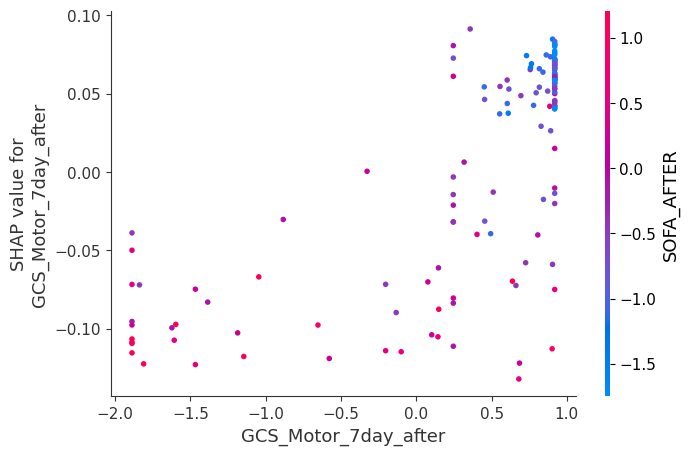

In [ ]:
shap.dependence_plot("GCS_Motor_7day_after", shap_values_scaled, X_test_scaled_df)
plt.show()

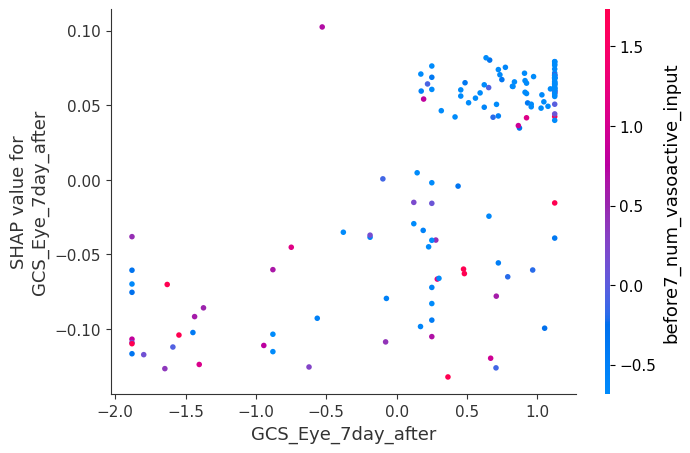

In [ ]:
shap.dependence_plot("GCS_Eye_7day_after", shap_values_scaled, X_test_scaled_df)
plt.show()

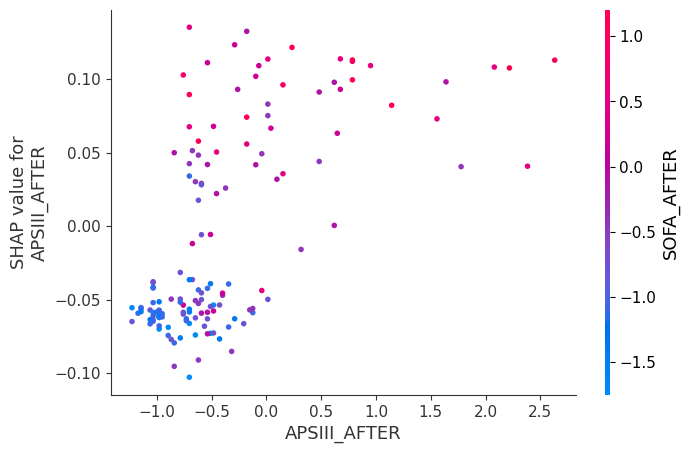

In [ ]:
shap.dependence_plot("APSIII_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()

###KNN shap

  0%|          | 0/144 [00:00<?, ?it/s]

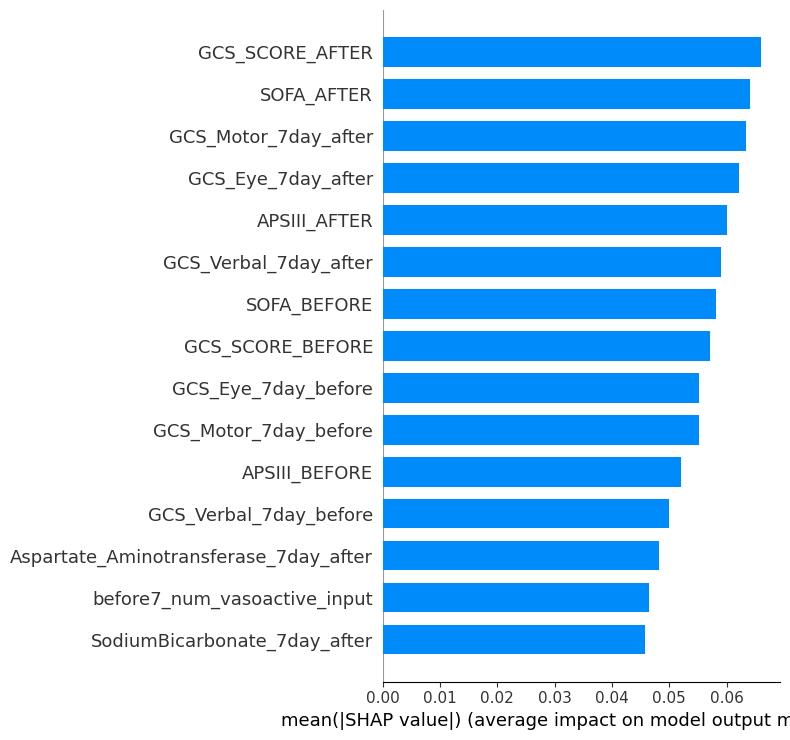

In [ ]:
import shap
import matplotlib.pyplot as plt
import joblib
import numpy as np

KNN_model = joblib.load('KNN_model.pkl')
# Initialize the SHAP explainer
explainer = shap.KernelExplainer(KNN_model.predict_proba, shap.kmeans(X_test_pca, 10))

# Calculate Shapley values
shap_values_pca = explainer(X_test_pca)

shap_values_scaled = np.dot(shap_values_pca.values[:,:,1], loading_matrix)

# Summary plot - shows feature importance
shap.summary_plot(shap_values_scaled, X_test_scaled_df, max_display=15, plot_type='bar')

plt.show()

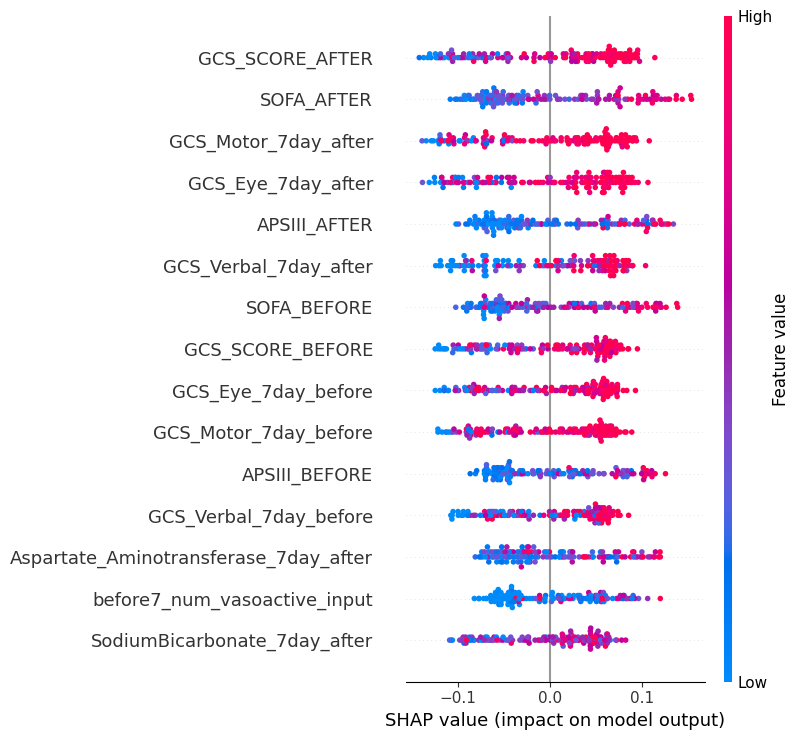

In [ ]:
shap.summary_plot(shap_values_scaled, X_test_scaled_df, max_display=15)

plt.show()

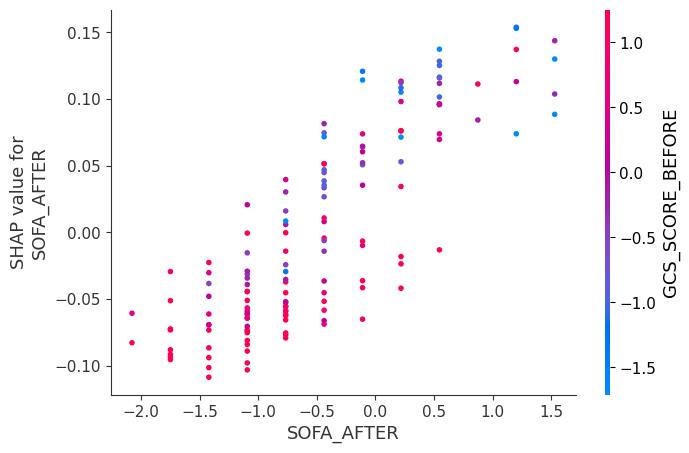

In [ ]:
shap.dependence_plot("SOFA_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()

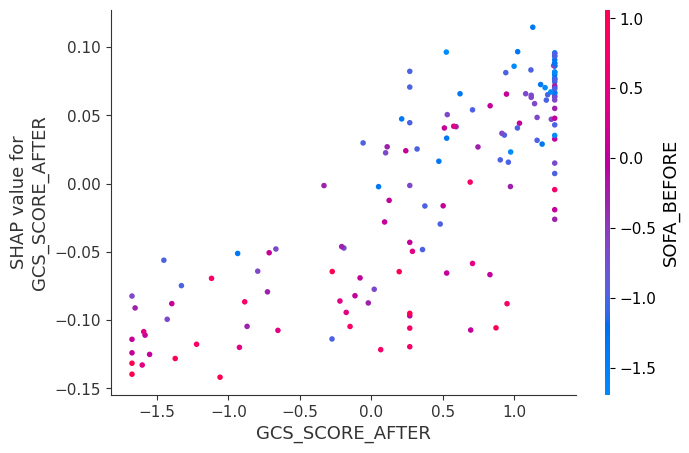

In [ ]:
shap.dependence_plot("GCS_SCORE_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()

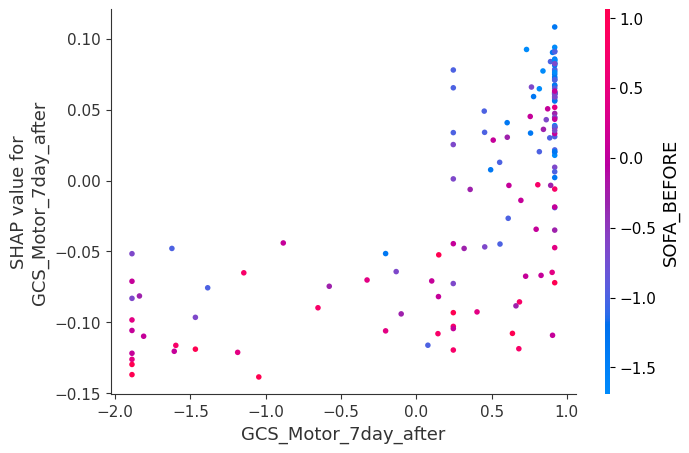

In [ ]:
shap.dependence_plot("GCS_Motor_7day_after", shap_values_scaled, X_test_scaled_df)
plt.show()

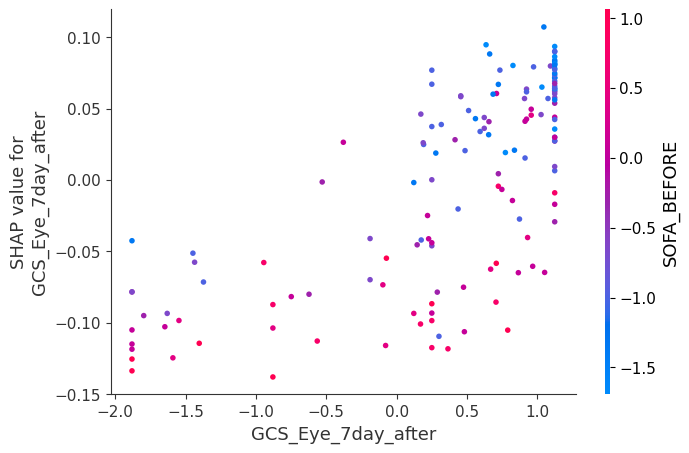

In [ ]:
shap.dependence_plot("GCS_Eye_7day_after", shap_values_scaled, X_test_scaled_df)
plt.show()

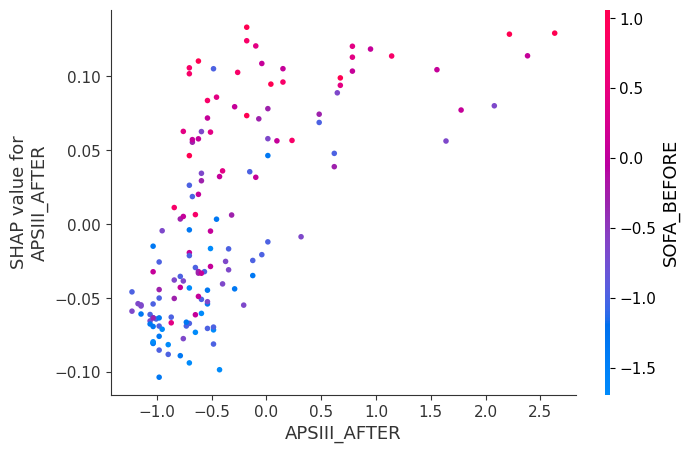

In [ ]:
shap.dependence_plot("APSIII_AFTER", shap_values_scaled, X_test_scaled_df)
plt.show()